----------
**The Hidden Truth behind Employee Leave**
=====================================

***Zoe Li***

----------

## The Problem

Why are you looking for a change? This is a question frequently asked by recruiters during an interview.

An interviewer would expect 'correct' answers: they enjoy their job, there is nothing they dislike about their current positions, and they are leaving for the right reasons - a better opportunity, more challenges, and career growth.

However, how many facts can be reflected by the sophiscated text-verison answers? For example, if a company is suffering from employee leave, should the company listen to 'words' of their employee or the 'fact' behind data?

Below, we will try to figure out why employee leave for other jobs and come up with suggestions for employers to keep staff.


I take advantage of a dataset from Kaggle.

- satisfaction level 
- last evaluation
- number of projects
- average working hours (per month)
- time spend at company
- work accident
- if promoted in last 5 years
- Department
- salary level (low, medium, high)
- employee left or not


The structure of the project: In Section 2, I inspect data and do feature engineer. In Section 3, I train and evaluate different classfication  models with cross validations. The main conclusions and insights are summarized in Section 4.

-------------------




In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The Data

In [2]:
data = pd.read_csv("./input/HR_comma_sep.csv")
data.head()
#data.columns

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
data.info()
#data.left = data.left.astype(int)
#print(data.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


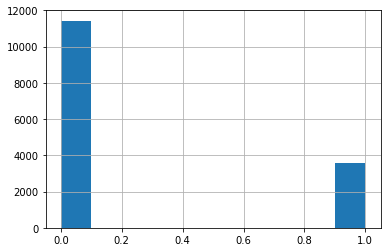

In [4]:
data['left'].hist()

### numerical variables 

(satisfaction level, last evaluation, average monthly hours, time spend company)

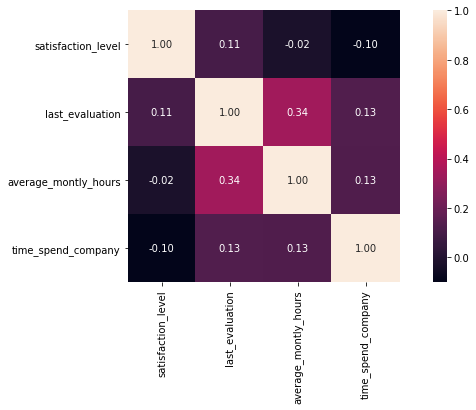

In [5]:
plt.subplots(figsize=(12, 5))
sns.heatmap(data[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']].corr(), fmt='.2f', annot=True, square=True)

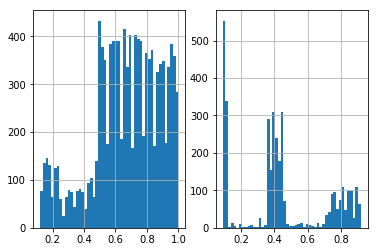

In [6]:
plt.subplot(121)
data[data['left'] == 0]['satisfaction_level'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['satisfaction_level'].hist(bins = 50);

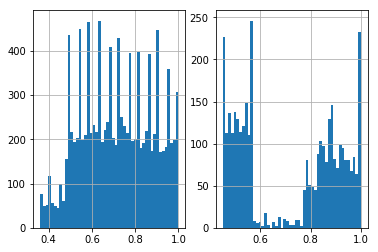

In [7]:
plt.subplot(121)
data[data['left'] == 0]['last_evaluation'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['last_evaluation'].hist(bins = 50);

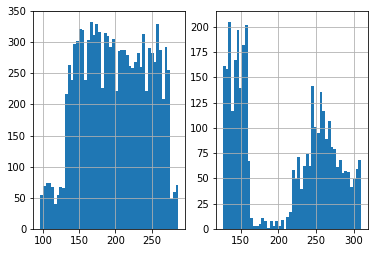

In [8]:
plt.subplot(121)
data[data['left'] == 0]['average_montly_hours'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['average_montly_hours'].hist(bins = 50);

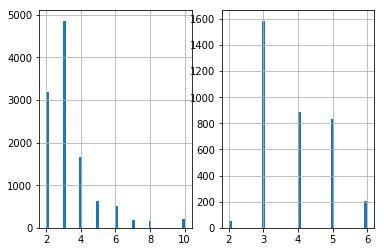

In [9]:
plt.subplot(121)
data[data['left'] == 0]['time_spend_company'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['time_spend_company'].hist(bins = 50);

### categorical variables
(work accident, promotion, department, number of projects, salary)

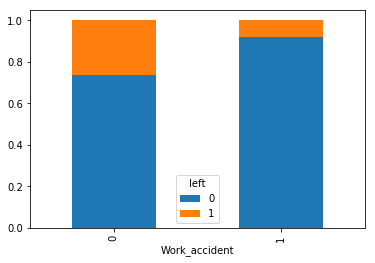

In [10]:
tmp_acc = pd.crosstab(data['Work_accident'], data.left)
tmp_acc.div(tmp_acc.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

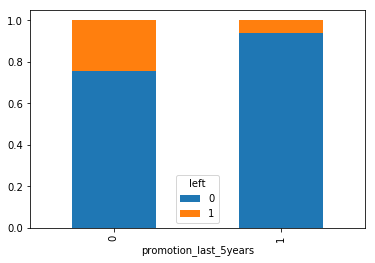

In [11]:
tmp_pro = pd.crosstab(data['promotion_last_5years'], data.left)
tmp_pro.div(tmp_pro.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

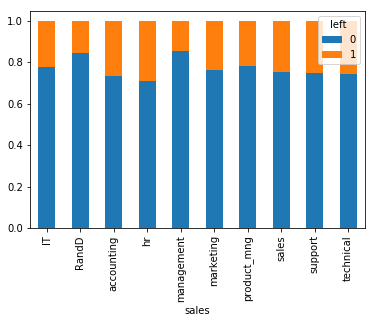

In [12]:
tmp_sales = pd.crosstab(data['sales'], data.left)
tmp_sales.div(tmp_sales.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

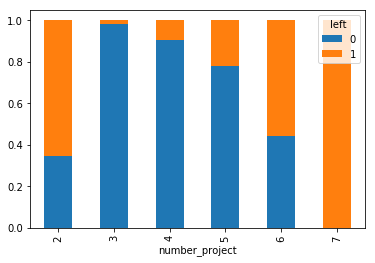

In [13]:
tmp_proj = pd.crosstab(data['number_project'], data.left)
tmp_proj.div(tmp_proj.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

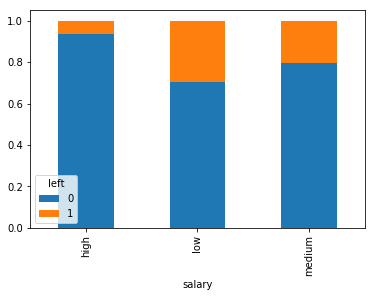

In [14]:
tmp = pd.crosstab(data.salary, data.left)
tmp.div(tmp.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

In [15]:
# tmp_time = pd.crosstab(data['time_spend_company'], data.left)
# tmp_time.div(tmp_time.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

### Dummy variables

In [16]:
from patsy import dmatrices 


y, X = dmatrices('left ~ satisfaction_level + last_evaluation + number_project + average_montly_hours + time_spend_company + Work_accident + promotion_last_5years + C(sales) + C(salary)',data, return_type = 'dataframe')

In [17]:
X = X.rename(columns = {
    'C(sales)[T.RandD]': 'Department: Random',
    'C(sales)[T.accounting]': 'Department: Accounting',
    'C(sales)[T.hr]': 'Department: HR',
    'C(sales)[T.management]': 'Department: Management',
    'C(sales)[T.marketing]': 'Department: Marketing',
    'C(sales)[T.product_mng]': 'Department: Product_Management',
    'C(sales)[T.sales]': 'Department: Sales',
    'C(sales)[T.support]': 'Department: Support',
    'C(sales)[T.technical]': 'Department: Technical',
    'C(salary)[T.low]': 'Salary: Low',
    'C(salary)[T.medium]': 'Salary: Medium'}) 
y = np.ravel(y) 

In [18]:
from sklearn import metrics 
from sklearn.model_selection import  KFold, train_test_split, cross_val_score 


def model_score(model):
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    m_score = cross_val_score(model, X, y, scoring="accuracy", cv=kf)
    return (m_score.mean())

#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Classifications

In [19]:

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.neural_network import MLPClassifier as MLP

model_list = [LR(),KN(),DT(),RF(),GB(),MLP()]


score_l = []
for model in model_list:
    score_l.append(model_score(model))
    
d={'Model':model_list,'Score':score_l}   
res_frame=pd.DataFrame(d)
res_frame



,Model,Score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.789586
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.937863
2,"DecisionTreeClassifier(class_weight=None, crit...",0.977732
3,"RandomForestClassifier(bootstrap=True, class_w...",0.987466
4,GradientBoostingClassifier(criterion='friedman...,0.975065
5,"MLPClassifier(activation='relu', alpha=0.0001,...",0.878591


### LogisticRegression

In [30]:
model = LR()
model.fit(X,y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_)))).head()

,0,1
0,Intercept,[-0.7241218101303709]
1,Department: Random,[-0.4646533540507806]
2,Department: Accounting,[0.11480746995707178]
3,Department: HR,[0.34470249740075476]
4,Department: Management,[-0.36197691576765323]


In [31]:
# print(model.score(X,y))
# model.coef_

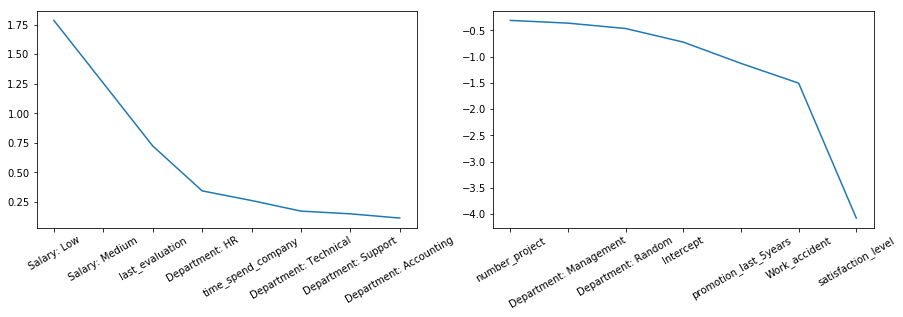

In [34]:
LRCoeff = pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))
LRCoeff.columns = ['features', 'coeffs']
Leave = LRCoeff.sort_values(by=['coeffs'],ascending=False).head(8)
NotLeave = LRCoeff.sort_values(by=['coeffs'], ascending=False).tail(7)

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(Leave['features'].iloc[0:18],Leave['coeffs'].iloc[0:18])
locs, labels = plt.xticks()
increase = plt.setp(labels, rotation=30)

plt.subplot(1, 2, 2)
plt.plot(NotLeave['features'].iloc[0:18],NotLeave['coeffs'].iloc[0:18])
locs, labels = plt.xticks()
decrease = plt.setp(labels, rotation=30)

**Predict** if one employee will leave: (e.g. high salary HR, satisfaction level 0.5, evalution last time 0.7, 4 projects, 160hr/month, 3 years, no promotion in last 5 years, no injury)

In [23]:
model.predict_proba([[1,0,0,1,0,0,0,0,0,0,0,0, 0.5, 0.7, 4.0, 160, 3.0, 0, 0]])

array([[0.9157868, 0.0842132]])

In [24]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 0)
# metrics.confusion_matrix(ytest, pred)
# print(metrics.classification_report(ytest, pred))

In [25]:
# model.predict_proba(X)
# pred = model.predict(X)
# (abs(pred-y)).sum() / len(y)

### Tunning hyperparameters

In [26]:
from sklearn.model_selection import GridSearchCV

def tuned_score(model, test_dic):
    gs = GridSearchCV(model, scoring="accuracy", cv=3, verbose=1,param_grid=test_dic,)
    gs.fit(X, y)
    return model_score(gs.best_estimator_)
    
LR_dic = {"penalty": ["l1","l2"],"C":[0.1, 1, 10, 50, 100]} #"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
KN_dic = {"n_neighbors":[1,3,5,7,9], }
DT_dic = {"max_depth": [2, 5, 10, 20, 50, 100, None],"min_samples_split":[2, 5, 10, 20, 50, 100]}
RF_dic = {"max_depth": [2, 5, 10, 20, 50, 100, None],"min_samples_split":[2, 5, 10, 20, 50, 100]}
#GB_dic = {"learning_rate": [0.1, 0.5, 1, 5],"min_samples_split":[2, 5, 10],"max_depth": [2, 5, 10, None]}

#GB_dic = {"learning_rate": [0.1, 0.5, 1, 5],"min_samples_split":[2, 5, 10, 20, 50, 100],"max_depth": [2, 5, 10, 20, 50, 100, None]}
MLP_dic = {"hidden_layer_sizes":[(5,), (10,), (50,), (100,)]}

para_l = [LR_dic, KN_dic, DT_dic, RF_dic, MLP_dic]
model_list = [LR(),KN(),DT(),RF(), MLP()]



score2_l = []
for i, model in enumerate(model_list):
    score2_l.append(tuned_score(model,para_l[i]))
    
d2={'Model':model_list,'Score':score2_l}   
res2_frame=pd.DataFrame(d2)
res2_frame


    
# gs = GridSearchCV(DecisionTreeClassifier(), scoring="accuracy", cv=3, verbose=1,
#                   param_grid={"max_depth": [2, 5, 10, 20, 50, 100, None], 
#                               "min_samples_split":[2, 5, 10, 20, 50, 100]}, )
# gs.fit(X, y)
# print(gs.best_params_)

# model_score(gs.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.0s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.1s finished


Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    4.1s finished


Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:   10.8s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   19.4s finished


,Model,Score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.792053
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.952730
2,"DecisionTreeClassifier(class_weight=None, crit...",0.979132
3,"RandomForestClassifier(bootstrap=True, class_w...",0.986799
4,"MLPClassifier(activation='relu', alpha=0.0001,...",0.857251


In [27]:
res_frame

,Model,Score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.789586
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.937863
2,"DecisionTreeClassifier(class_weight=None, crit...",0.977732
3,"RandomForestClassifier(bootstrap=True, class_w...",0.987466
4,GradientBoostingClassifier(criterion='friedman...,0.975065
5,"MLPClassifier(activation='relu', alpha=0.0001,...",0.878591


## Summary

From the project, we can obtain direct insights using logistic regression:
- If salary is not high, employee tend to leave. People from HR department tend to leave.
- The employee in the management department tend not to leave. If employee got promotion or had work accident, he/she tend not to leave.
